In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pylab as pl

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso, NODE
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

import GPy

from jaxbo.mcmc_models import ReimannianMFGPclassifierFourier, ReimannianGPclassifierFourier
from jaxbo.input_priors import uniform_prior
from sklearn.metrics import balanced_accuracy_score
from meshutils.Mesh import Mesh
import meshio
from scipy.linalg import eigh

import seaborn as sns

In [2]:
def reverse_sde3(initial, forward_drift, dispersion, score, noises, ts=train_ts): # Pass in both the initial noise and the "infused" noise from outside
    def f(carry, params):
        t = params[0]
        dt = params[1]
        noise = params[2:]
        x = carry
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return x, ()
    
    dts = ts[1:] - ts[:-1]
    params = jnp.hstack([train_ts[:-1][:,None], dts[:,None], noises])
    x, _ = scan(f, initial, params)
    return x

def reverse_sde2(rng, initial, forward_drift, dispersion, score, ts=train_ts): # Pass in the initial noise from outside
    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jax.random.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = random.normal(step_rng, x.shape)
        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = random.split(rng)
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    (x, _), _ = scan(f, (initial, rng), params)
    return x

In [3]:
n_params = 1
batch_size = 10
x = jnp.zeros(n_params*batch_size).reshape((batch_size, n_params))
time = jnp.ones((batch_size, 1))
score_model = ApproximateScore() # from diffusion_utils
params_diff = score_model.init(rng, x, time) # from diffusion_utils

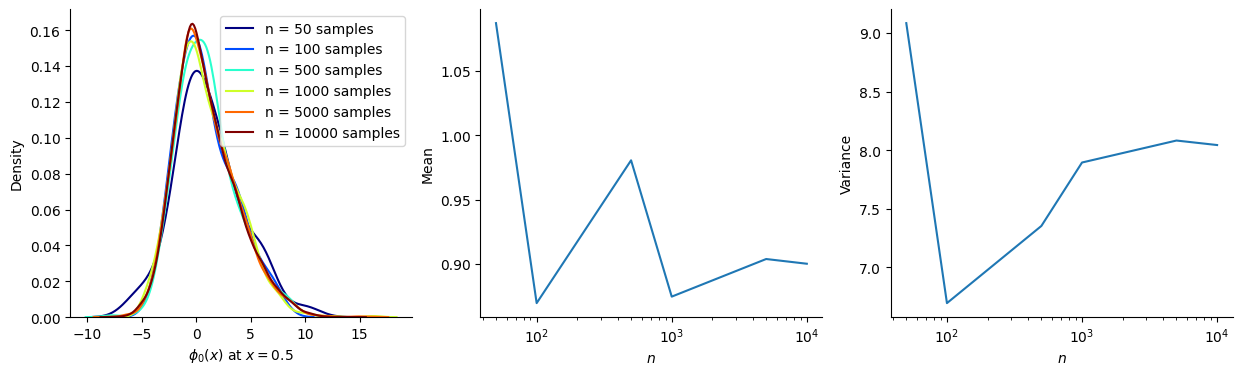

In [6]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)

n = 51
i = 25
n_list = [50, 100, 500, 1000, 5000, 10000]
colors = pl.cm.jet(np.linspace(0,1,len(n_list)))
means = []
varrs = []
for n_samples, c in zip(n_list, colors):
    X = np.linspace(0.,1.0,n)
    X = X[:,None]
    mu = np.zeros((n))
    C = k.K(X,X) + np.eye(n)*1.0e-6
    L = np.linalg.cholesky(C)
    
    score_model = ApproximateScore()

    φ_0 = []
    for j in range(n_samples):
        # Z = np.random.multivariate_normal(mu,C,n_params)
        Z = mu + L @ np.random.randn(mu.shape[0])
        Z = Z[None,:]

        D = train_ts.shape[0]-1
        Z_t = []
        for _ in range(D):
            Z_t.append(mu + L @ np.random.randn(mu.shape[0]))
        Z_t = np.array(Z_t).T

        trained_score = lambda x, t: score_model.apply(params_diff, x, t)

        φ_t = Z[:,i].T
        φ_t = φ_t[None,:]
        # l = reverse_sde2(rng, φ_t, drift, dispersion, trained_score)[0]
        noise = Z_t[i,:]
        noise = noise[:,None]
        l = reverse_sde3(φ_t, drift, dispersion, trained_score, noise)[0]
        φ_0.append(l)
        # ax[0].plot(X, Z.T, color=c, marker='.')
    sns.kdeplot(np.array(φ_0).flatten(), color=c, ax=ax[0], label="n = " + str(n_samples) + " samples")
    # ax[1].legend()

    means.append(np.mean(φ_0))
    varrs.append(np.var(φ_0))

# ax[0].set(xlabel='$x$', ylabel='$\phi_t(x)$')
ax[0].legend()
ax[0].set(xlabel='$\phi_0(x)$ at $x=0.5$')
ax[1].plot(n_list, means, label='mean')
ax[1].set(xscale='log', xlabel='$n$', ylabel='Mean')
ax[2].plot(n_list, varrs, label='variance')
ax[2].set(xscale='log', xlabel='$n$', ylabel='Variance')

for axi in ax:
    axi.spines[['right', 'top']].set_visible(False)
fig.savefig('tikz/fig_SDE_convergence/toprow.jpg')

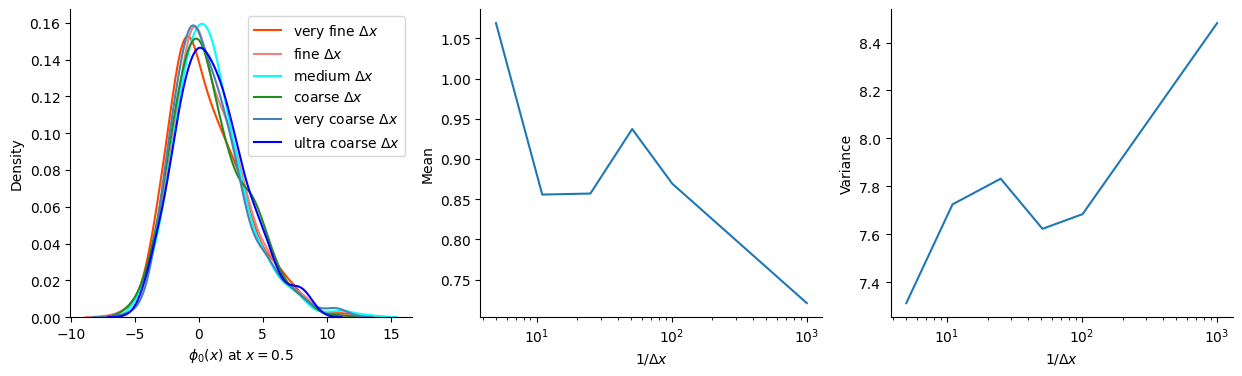

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)

ns = [1001, 101, 51, 25, 11, 5]
i_middles = [500, 50, 25, 12, 5, 2]
colors = ['orangered', 'lightcoral', 'aqua', 'forestgreen', 'steelblue', 'blue']
labels = ['very fine $\Delta x$', 'fine $\Delta x$', 'medium $\Delta x$', 'coarse $\Delta x$', 'very coarse $\Delta x$', 'ultra coarse $\Delta x$']

means = []
varrs = []
for n, c, label, i in zip(ns, colors, labels, i_middles):
    X = np.linspace(0.,1.0,n)
    X = X[:,None]
    mu = np.zeros((n))
    C = k.K(X,X) + np.eye(n)*1.0e-6
    L = np.linalg.cholesky(C)
    
    score_model = ApproximateScore()

    φ_0 = []
    for j in range(500):
        Z = mu + L @ np.random.randn(mu.shape[0])
        Z = Z[None,:]

        D = train_ts.shape[0]-1
        Z_t = []
        for _ in range(D):
            Z_t.append(mu + L @ np.random.randn(mu.shape[0]))
        Z_t = np.array(Z_t).T

        trained_score = lambda x, t: score_model.apply(params_diff, x, t)

        φ_t = Z[:,i].T
        φ_t = φ_t[None,:]
        # l = reverse_sde2(rng, φ_t, drift, dispersion, trained_score)[0]
        noise = Z_t[i,:]
        noise = noise[:,None]
        l = reverse_sde3(φ_t, drift, dispersion, trained_score, noise)[0]
        φ_0.append(l)
        # ax[0].plot(X, Z.T, color=c, marker='.')
    sns.kdeplot(np.array(φ_0).flatten(), color=c, ax=ax[0], label=label)
    ax[0].legend()

    means.append(np.mean(φ_0))
    varrs.append(np.var(φ_0))

# ax[0].set(xlabel='$x$', ylabel='$\phi_t(x)$')
ax[0].set(xlabel='$\phi_0(x)$ at $x=0.5$')
ax[1].plot(ns, means, label='mean')
ax[1].set(xscale='log', xlabel='$1/\Delta x$', ylabel='Mean')
# ax[1].legend()
ax[2].plot(ns, varrs, label='variance')
ax[2].set(xscale='log', xlabel='$1/\Delta x$', ylabel='Variance')
# ax[2].legend()

for axi in ax:
    axi.spines[['right', 'top']].set_visible(False)
fig.savefig('tikz/fig_SDE_convergence/midrow.jpg')

* Third thing to consider: # of samples (currently 50) 
* Redo these with larger sample size
* First do the third study to find a good number of samples that works

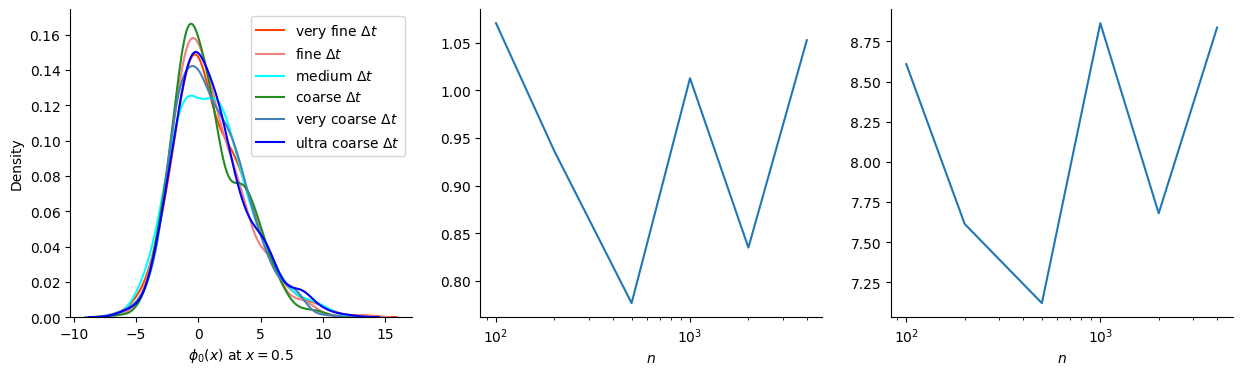

In [9]:
fig, ax = plt.subplots(1,3, figsize=(15,4))
k = GPy.kern.RBF(input_dim=1,lengthscale=0.4)

ns = [4000, 2000, 1000, 500, 200, 100]
colors = ['orangered', 'lightcoral', 'aqua', 'forestgreen', 'steelblue', 'blue']
labels = ['very fine $\Delta t$', 'fine $\Delta t$', 'medium $\Delta t$', 'coarse $\Delta t$', 'very coarse $\Delta t$', 'ultra coarse $\Delta t$']

means = []
varrs = []
for n, c, label in zip(ns, colors, labels):
    ts = jnp.arange(1, n)/(n-1)
    X = np.linspace(0.,1.0,50)
    X = X[:,None]
    mu = np.zeros((50))
    C = k.K(X,X) + np.eye(len(X))*1.0e-6
    L = np.linalg.cholesky(C)
    
    score_model = ApproximateScore()

    φ_0 = []
    for j in range(500):
        Z = mu + L @ np.random.randn(mu.shape[0])
        Z = Z[None,:]

        D = train_ts.shape[0]-1
        Z_t = []
        for _ in range(D):
            Z_t.append(mu + L @ np.random.randn(mu.shape[0]))
        Z_t = np.array(Z_t).T

        trained_score = lambda x, t: score_model.apply(params_diff, x, t)

        φ_t = Z[:,i].T
        φ_t = φ_t[None,:]
        noise = Z_t[i,:]
        noise = noise[:,None]
        l = reverse_sde3(φ_t, drift, dispersion, trained_score, noise)[0]
        φ_0.append(l)
        # ax[0].plot(X, Z.T, color=c, marker='.')
    sns.kdeplot(np.array(φ_0).flatten(), color=c, ax=ax[0], label=label)
    ax[0].legend()

    means.append(np.mean(φ_0))
    varrs.append(np.var(φ_0))


# ax[0].set(xlabel='$x$', ylabel='$\phi_t(x)$')
ax[0].set(xlabel='$\phi_0(x)$ at $x=0.5$')
ax[1].plot(ns, means, label='mean')
ax[1].set(xscale='log', xlabel='$n$')
# ax[1].legend()
ax[2].plot(ns, varrs, label='variance')
ax[2].set(xscale='log', xlabel='$n$')
# ax[2].legend()

for axi in ax:
    axi.spines[['right', 'top']].set_visible(False)
fig.savefig('tikz/fig_SDE_convergence/botrow.jpg')